In [1]:
#!pip install numba
from numba import jit # eif_new relies on numba jit compiled functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import time
import eif_old as iso2
import seaborn as sb
from sklearn.ensemble import IsolationForest

%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, "../")
import eif_new as iso_new

In [3]:
# Create data
mean = [0, 0, 0 ]
cov = [[1, 0, 0.], [0, 0.1, 0.0], [0,0,1]]  # diagonal covariance
Nobjs = 5000
np.random.seed(1)
x, y, z = np.random.multivariate_normal(mean, cov, Nobjs).T
# Add manual outlier
x[0] = 3.3
y[0] = 3.3
z[0] = 3.3
X = np.array([x,y,z]).T

In [4]:
rng = 42
Ntrees = 500
Nsamples = 256

In [5]:
# scikit learn solution
ss = time.time()
F0 = IsolationForest(n_estimators=Ntrees, max_samples=Nsamples, random_state=rng).fit(X)
S0 = F0.score_samples(X)*-1
ee = time.time()
print('{:.3f} sec, Scikit Learn'.format(ee-ss))

0.946 sec, Scikit Learn


In [6]:
ss = time.time()
F1 = iso.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0, seed=rng)
S1 = F1.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Cython Version'.format(ee-ss))

1.310 sec, EIF Cython Version


In [7]:
ss = time.time()
F2 = iso2.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0)
S2 = F2.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Old Python Version'.format(ee-ss)) # 422 sec vs 15 new

43.649 sec, EIF Old Python Version


In [8]:
# the first execution will compile all numba functions
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, exlevel=0, random_state=rng).fit(X[:10])
S3 = F3.compute_paths(X[:10])
# this is the valid execution
ss = time.time()
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, exlevel=0, random_state=rng).fit(X)
S3 = F3.compute_paths(X)
ee = time.time()
print('{:.3f} sec, EIF New Python Version'.format(ee-ss)) 

1.250 sec, EIF New Python Version


Text(0.5, 0, 'Scores')

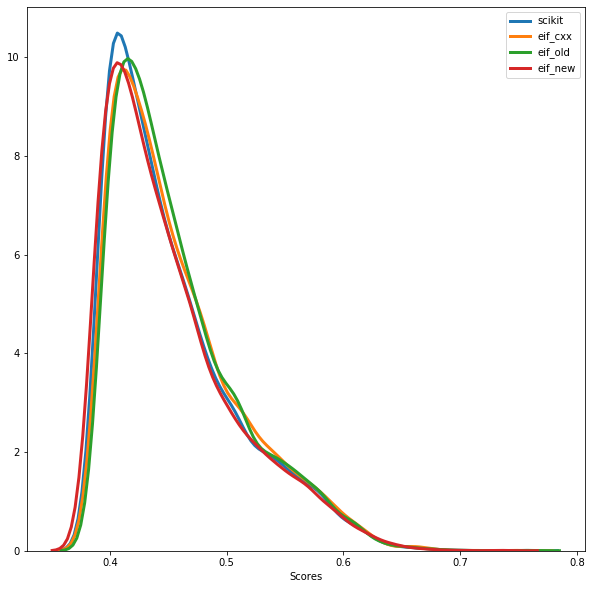

In [9]:
plt.figure(figsize=(10,10))
sb.kdeplot(S0, lw=3, label='scikit', clip=(0.35, 0.8))
sb.kdeplot(S1, lw=3, label='eif_cxx', clip=(0.35, 0.8))
sb.kdeplot(S2, lw=3, label='eif_old', clip=(0.35, 0.8))
sb.kdeplot(S3, lw=3, label='eif_new', clip=(0.35, 0.8))
plt.legend(loc=0)
plt.xlabel('Scores')

In [10]:
import pickle
versions = ("old", "new")
for v, obj in zip(versions, (F2, F3)):
    pkl_fn = "eif_%s.pkl"%v
    with open(pkl_fn, "wb") as file:
        pickle.dump(obj, file)
    print("EIF %s Python Version dump size: %.2f Mb"%(v, os.stat(pkl_fn).st_size/1024**2,))

EIF old Python Version dump size: 37.38 Mb
EIF new Python Version dump size: 4.39 Mb


In [11]:
#!pip install joblib
import joblib
versions = ("old", "new")
for v, obj in zip(versions, (F2, F3)):
    jbl_fn = "eif_%s.jbl.lzma"%v # lzma compression
    t0 = time.time()
    joblib.dump(obj, jbl_fn)
    dt = time.time()-t0
    print("EIF %s Python Version joblib dump size %.2f Mb in %.3f sec"%(v, os.stat(jbl_fn).st_size/1024**2, dt))

EIF old Python Version joblib dump size 3.55 Mb in 17.518 sec
EIF new Python Version joblib dump size 0.38 Mb in 0.482 sec


In [13]:
%load_ext line_profiler
%lprun -f F3.populate_nodes F3.fit(X)